<h1><b>Example </b></h1>

<n>The experiment employs an attenuated laser source, a 50/50 fiber coupler, and two single-photon detectors. The attenuated laser beam is modulated at frequency of 1 MHz and with duty cycle of 3.5%. The modulated light is injected into the fiber coupler, where each photon randomly exits through one of the two output arms. Detection events at the output arms are recorded by single-photon detectors connected to a time-tagging module. By varying the laser attenuation, the photon detection rate at the detectors is controlled. In this example, datasets acquired at detection rates of 50 kb/s, 20 kb/s, and 3 kb/s are analyzed. </n>

In [1]:
# import the TimetagsOut library 
from TimetagsOut import TimetagsOut

# import matplotlib for data visualization 
import matplotlib.pyplot as plt

<h3><b>Preparation of raw data </b></h3> 

In [3]:
# create timetagOut object for each raw data using the initializer 

data50 = TimetagsOut('50kb/Single_photon_17.h5')
data20 = TimetagsOut('20kb/Single_photon_15.h5')
data3 = TimetagsOut('3kb/Single_photon_12.h5')

In [4]:
# preview the first 10 rows of datasheets 
data50.preview()

number of rows: 53408017


,Channel,Edge,Timetag,ProcessedTimetag
53408007,1.0,1.0,6.784966e+12,558.433196
53408008,1.0,1.0,6.784966e+12,558.433203
53408009,4.0,1.0,6.784966e+12,558.433208
53408010,4.0,1.0,6.784966e+12,558.433219
53408011,1.0,1.0,6.784966e+12,558.433221
53408012,1.0,1.0,6.784966e+12,558.433227
53408013,4.0,1.0,6.784966e+12,558.433232
53408014,4.0,1.0,6.784966e+12,558.433259
53408015,4.0,1.0,6.784966e+12,558.433260
53408016,1.0,1.0,6.784966e+12,558.433267


<h3><b> Data Prcocessing </b></h3>
<n>use window_extract_bits() instant function to filter and convert the raw data into binary numbers. This steps must be done first before any post-processing (randomness extraction)</n>

In [5]:
bit50, eff50 = data50.window_extract_bits(ch_1=1.0, ch_2 = 4.0, window_width=1e-6, write_to_file=True)

49213431 bits are generated. 23243354 zeros and 25970077 ones


In [6]:
bit20, eff20 = data20.window_extract_bits(ch_1=1.0, ch_2 = 4.0, window_width=1e-6, write_to_file=True)

50601573 bits are generated. 23909512 zeros and 26692061 ones


In [7]:
bit3, eff3 = data3.window_extract_bits(ch_1=1.0, ch_2 = 4.0, window_width=1e-6, write_to_file=True)

30936378 bits are generated. 14637711 zeros and 16298667 ones


<h3><b>Analysis</b></h3>
<n> In this section, the bias per block, the min-entropy and autocorrelation generated from the previous section are determined </n> 

In [8]:
# the bitstream is divided into block with block size = 1_000_000, the bias of the bitstream is determined using bias_per_block().

x50, bias50 = data50.bias_per_block()
x20, bias20 = data20.bias_per_block()
x3, bias3 = data3.bias_per_block()

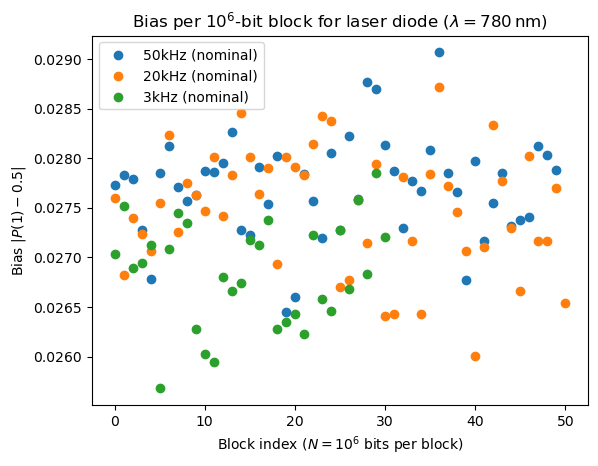

In [9]:
# data visualization 
plt.scatter(x50,bias50, color = 'C0', label = '50kHz (nominal)')
plt.scatter(x20,bias20, color = 'C1', label = '20kHz (nominal)')
plt.scatter(x3,bias3, color = 'C2', label = '3kHz (nominal)')
plt.xlabel(r'Block index ($N = 10^6$ bits per block)')
plt.ylabel(r'Bias $|P(1) - 0.5|$')
plt.title(r'Bias per $10^6$-bit block for laser diode ($\lambda = 780\,\mathrm{nm}$)')
plt.legend()
plt.show()

In [10]:
# determine autocorrelation of the bitstream using static method : autocorrelation()
xy_fit50, xy_autocorr50,tau50 = TimetagsOut.autocorrelation(bit50, 1e6, 100)
xy_fit20, xy_autocorr20,tau20 = TimetagsOut.autocorrelation(bit20, 1e6, 100)
xy_fit3, xy_autocorr3,tau3 = TimetagsOut.autocorrelation(bit3, 1e6, 100)

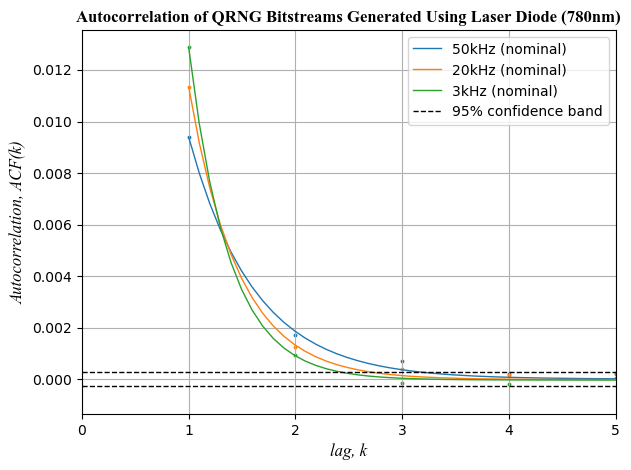

In [11]:
# data visualization with fitting 
from matplotlib.ticker import MaxNLocator
import numpy as np

plt.scatter(*xy_autocorr50, s = 3)
plt.plot(*xy_fit50, linewidth = 1, color = 'C0', label='50kHz (nominal)')

plt.scatter(*xy_autocorr20, s = 3)
plt.plot(*xy_fit20, linewidth = 1, color = 'C1', label='20kHz (nominal)')

plt.scatter(*xy_autocorr3, s = 3)
plt.plot(*xy_fit3, linewidth = 1, color = 'C2', label='3kHz (nominal)')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# confidence interval
conf = 2/np.sqrt(50e6)
plt.axhline(conf,  color='k', linestyle='--', alpha=1, linewidth = 1,label = '95% confidence band')
plt.axhline(-conf, color='k', linestyle='--', alpha=1, linewidth = 1)



# graph title 
plt.xlabel(f'lag, k', fontname = "Times New Roman", fontsize = 12, fontstyle = 'italic')
plt.ylabel(f'Autocorrelation, ACF(k)', fontname = "Times New Roman", fontsize = 12 , fontstyle = 'italic')
plt.xlim((0,5))
plt.title(f"Autocorrelation of QRNG Bitstreams Generated Using Laser Diode (780nm)", fontname = 'Times New Roman', fontsize = 12, fontweight = 'bold')
plt.legend()
plt.rcParams['figure.dpi'] = 300
plt.grid()
plt.tight_layout()

plt.show()


In [12]:
# calculate the min-entropy, h_min using static method: min_entropy()

h_min = TimetagsOut.min_entropy(bit50, bit20, bit3)

print(f' min-entropy for 50kb = {h_min[0]} \n min-entropy for 20kb = {h_min[1]} \n min-entropy for 3kb = {h_min[2]}')

 min-entropy for 50kb = 0.9222018084276656 
 min-entropy for 20kb = 0.9227715272279753 
 min-entropy for 3kb = 0.924550320120147


<h3><b>Post-Processing</b></h3>
<n>In this section, the bitstreams, which is bias and temporal correlated, are mitigated using toeplitz hashing.</n>

In [13]:
data50.toeplitz_hashing(h_min[0],write_to_file=True)
data20.toeplitz_hashing(h_min[1],write_to_file=True)
data3.toeplitz_hashing(h_min[2],write_to_file=True)

# or 
b50, ef50 = data50.toeplitz_hashing(h_min[0],write_to_file=True)

33064936 bits are generated: 16530286 zeros and 16534650 ones
Toeplitz hashing efficiency = 0.6719
33997864 bits are generated: 16998763 zeros and 16999101 ones
Toeplitz hashing efficiency = 0.6719
20845590 bits are generated: 10422458 zeros and 10423132 ones
Toeplitz hashing efficiency = 0.6738
33064936 bits are generated: 16528352 zeros and 16536584 ones
Toeplitz hashing efficiency = 0.6719


<n>other post-processing option: Von-Neumann debiasing and SHA-256 hashing </n> 

In [14]:
# von-neumann debiasing 
data50.von_neumann(write_to_file = True)

# or 
b50, ef50 = data50.von_neumann(write_to_file = True)

12147100 bits are generated. 6074023 zeros and 6073077 ones
12147100 bits are generated. 6074023 zeros and 6073077 ones


In [15]:
# SHA-256 hashing 
data50.hashing256(write_to_file=True)

# or 
b50, ef50 = data50.hashing256(write_to_file=True)

24606464 bits generated (12298572 zeros, 12307892 ones)
24606464 bits generated (12298572 zeros, 12307892 ones)
